In [1]:
import os
# import open3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib import colors
plt.rcParams["font.family"] = "serif" # Font controller
plt.rcParams["font.serif"] = ["Arial"]
plt.rcParams["font.size"] = 11 # Default=10
import pickle
import vis_utilities as vis_util
import eval_utilities as eval_util
import matplotlib.lines as mlines
import configobj

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
BASE_CFG_list = ['octree-raht']
SUB_CFG_dict = {'octree-raht':['octree_raht_lossy_lossy_no_dup', 'octree_raht_lossy_lossy_keep_dup', 
                               'octree_raht_lossy_lossy_no_dup_distance'],
               'octree-predlift':['lossy-geom-lossy-attrs'],
               'predgeom-raht':['lossy-geom-lossy-attrs'],
               'predgeom-predlift':['lossy-geom-lossy-attrs']}
rate_list_dict = {'octree-raht':[[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5]],
               'octree-predlift':[[1, 2, 3, 4, 5, 6]],
               'predgeom-raht':[[1, 2, 3, 4, 5, 6]],
               'predgeom-predlift':[[1, 2, 3, 4, 5, 6]]}

class_list=['Car','Pedestrian','Cyclist']
difficulty_list=['Easy','Mod.','Hard']

edges = np.array([[0, 10], [10, 20], [20, 30], [30, 40],
                  [40, 70]])
edges_txt = ['0-10', '10-20','20-30','30-40','40-70']
metric = 'mAP3d_R40'
IoU_criteria = 0 
difficulty = 1

range_types = [0, 1, 2, 3, 4]

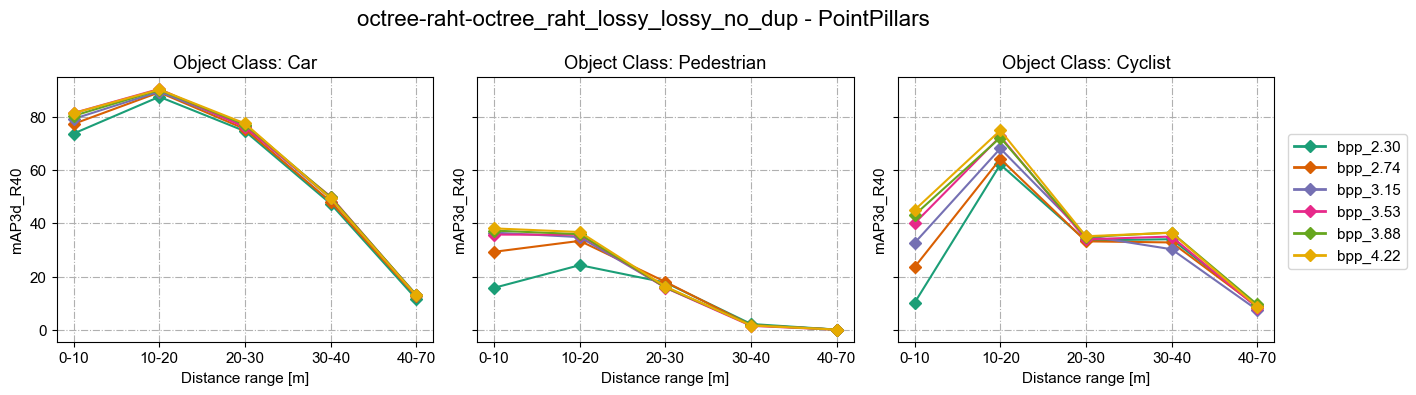

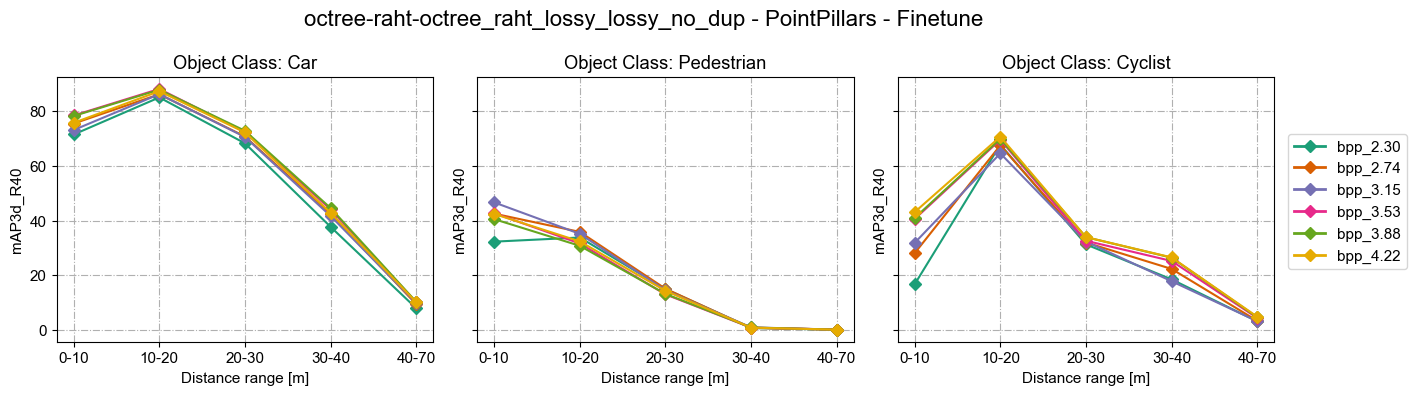

In [3]:
consistent_colormap = plt.cm.get_cmap('Dark2')
BASE_CFG = 'octree-raht'
SUB_CFG = 'octree_raht_lossy_lossy_no_dup'
AP_data_dir_roots = ['/home/user/PCcompression/Results/AP_files/', '/home/user/PCcompression/Results/AP_files_pp_ft/']
rate_list = [1, 2, 3, 4, 5, 6]
models = ['PointPillars', 'PointPillars - Finetune']
bitrate_root = '/home/user/PCcompression/Results/GPCC_files/output_kitti_training/'

BASE_CFG_baseline = 'octree-raht'
SUB_CFG_baseline = 'octree_raht_lossy_lossy_no_dup'
bitrate_baseline_dir = bitrate_root + BASE_CFG_baseline + '/' + SUB_CFG_baseline + '/'
rate_baseline = 4


    

for model_ind, AP_data_dir_root in enumerate(AP_data_dir_roots):
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)
    fig.set_size_inches(13,4)
    legend_elements = []


    result_dir_root = AP_data_dir_root + BASE_CFG + '/' + SUB_CFG + '/'
    bitrate_dir = bitrate_root + BASE_CFG + '/' + SUB_CFG + '/'

    rets = eval_util.load_one_CFG_dir(BASE_CFG, SUB_CFG, AP_data_dir_root, rate_list, bitrate_dir)
    metrics_cfg, CFG_full_name, rate_dict, rate_list = rets

    result_baseline_root = AP_data_dir_root + BASE_CFG_baseline + '/' + SUB_CFG_baseline + '/'
    AP_baseline = []
    for range_type in range_types:
        result_baseline_dir = result_baseline_root + 'r0' + str(rate_baseline) + '/range_' + str(range_type) + '/'
        metrics = eval_util.load_AP_single_setting(result_baseline_dir)
        AP_baseline.append(metrics)

    AP_baseline = np.asarray([AP_baseline[i][metric] for i, _ in enumerate(range_types)])
    br_baseline = eval_util.load_br_dir(bitrate_baseline_dir, [rate_baseline])

    for obj_class, obj_class_name in enumerate(class_list):
        # AP_raw_array = [AP_all_ranges_raw[range_type][metric][obj_class, difficulty, IoU_criteria] for range_type in range_type_list]
        for rate_ind, rate in enumerate(rate_list):
            AP_all_rates = []
            for range_type  in range_types:
                result_dir = result_dir_root +'r0'+str(rate) + '/range_' + str(range_type) + '/'
                metrics = eval_util.load_AP_single_setting(result_dir)
                AP_all_rates.append(metrics)

            
            AP = np.asarray([AP_all_rates[i][metric][obj_class, difficulty, IoU_criteria] for i, _ in enumerate(range_types)])
            axs[obj_class].plot(range_types, AP,'D-', color=consistent_colormap.colors[rate-1], label='bpp_{:.2f}'.format(rate_dict['total_bpp'][rate_ind]))# Missing x

            if obj_class == 0:
                    legend_elements.append(mlines.Line2D([0], [0], marker='D',
                                                         c=consistent_colormap.colors[rate-1], lw=2, ls='-', 
                                                         label='bpp_{:.2f}'.format(rate_dict['total_bpp'][rate_ind])))

        axs[obj_class].set_ylabel(metric)
        axs[obj_class].set_xlabel('Distance range [m]')
        axs[obj_class].set_title('Object Class: '+obj_class_name)
        axs[obj_class].grid(True, linestyle='-.')
        axs[obj_class].set_xticks(range(0, len(edges)), edges_txt)
            # axs[obj_class].plot(AP_raw_array,'--', color='blue', label='Raw data')# Missing x
        # axs[obj_class].plot(range_types, AP_baseline[:, obj_class, difficulty, IoU_criteria],'--', color='blue', 
        #                     label='baseline_bpp_{:.2f}'.format(br_baseline['total_bpp'][0]))# Missing x
        # axs[obj_class].legend(loc='upper right')

    # legend_elements.append(mlines.Line2D([0], [0], marker='none',
    #                     c="blue", lw=2, ls='--', 
    #                     label='baseline_bpp_{:.2f}'.format(br_baseline['total_bpp'][0])))

    fig.suptitle(BASE_CFG + '-' + SUB_CFG + ' - ' + models[model_ind], fontsize=16)
    fig.legend(handles=legend_elements, bbox_to_anchor=(0.99, 0.5), loc='center left')
